# Matrix multiplication

In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data / "mnist.pkl.gzip"

In [ ]:
from urllib.request import urlretrieve
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

.rw-r--r--@ 16Mi tom 23 Dec 23:40 -N mnist.pkl.gzip


In [ ]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train.shape

(50000, 784)

In [ ]:
im_dim = math.sqrt(784); im_dim

28.0

## Chunks

In [ ]:
from itertools import islice
def chunks(x, sz):
    # for i in range(0, len(x), sz): yield x[i:i+sz]
    it = iter(x)
    return list(iter(lambda: list(islice(it, sz)), []))

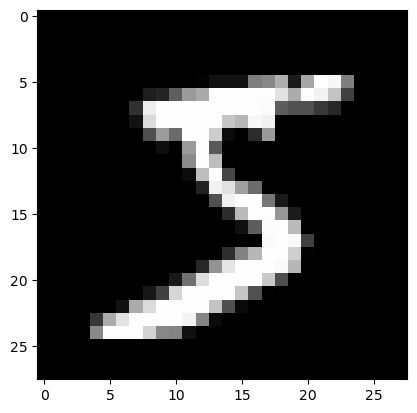

In [ ]:
v = list(x_train[0])
v_t = list(chunks(v, 28))

mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(v_t)
plt.show()

In [ ]:
from numba import njit

ModuleNotFoundError: No module named 'numba'

In [ ]:
def dot(x, y):
    return sum(i*j for i, j in zip(x, y))

class Matrix:
    def __init__(self, x):
        self._x = x
        
    def __getitem__(self, idxs):
        cur = self._x
        if isinstance(idxs, int):
            idxs = [idxs]
        for ix in idxs:
            cur = cur[ix]
        return cur

    def __repr__(self):
        return f"Matrix {self.shape()}\n{self._x}"

    def shape(self):
        return (len(self._x), len(self._x[0]))

    @staticmethod
    def zeros(rows, cols):
        return Matrix([[0 for _ in range(cols)] for _ in range(rows)])
        
    @staticmethod
    def zeros_like(instance): return Matrix.zeros(*instance.shape())
        
    def transpose(self):
        rows, cols = self.shape()
        new_x = Matrix.zeros(cols, rows)
        for i in range(rows):
            for j in range(cols):
                new_x._x[j][i] = self[i, j]
        return new_x

    def __matmul__(self, y):
        # (x, d) @ (d, y)
        assert len(self._x[0]) == len(y._x)
        res_rows, res_cols = len(self._x), len(y[0]) # x, y
        mul_dim = len(self._x[0])
        res = Matrix([[0 for _ in range(res_cols)] for _ in range(res_rows)])
        # y_t = y.transpose() # y, d
        for i in range(res_rows): # x
            for j in range(res_cols): # y
                # dot(x[i], y[:, j])
                # transposed matrix swapped rows and cols
                # res._x[i][j] = dot(self._x[i], y_t[j])
                
                # or alternatively:
                for k in range(mul_dim):
                    res._x[i][j] += self[i, k] * y[k, j]
                    
        return res

v_t = Matrix(chunks(v, 28))
# v_t @ v_t.transpose()
a = Matrix([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]])
a @ a.transpose()

Matrix (3, 3)
[[14, 38, 62], [38, 126, 214], [62, 214, 366]]

In [ ]:
%time _=v_t @ v_t.transpose()

CPU times: user 18.6 ms, sys: 3 ms, total: 21.6 ms
Wall time: 24.9 ms


## Outer product

In [ ]:
import torch

In [ ]:
a = torch.arange(5)
b = torch.arange(5) * 10
a, b

(tensor([0, 1, 2, 3, 4]), tensor([ 0, 10, 20, 30, 40]))

In [ ]:
a[None, :] * b[:, None]

tensor([[  0,   0,   0,   0,   0],
        [  0,  10,  20,  30,  40],
        [  0,  20,  40,  60,  80],
        [  0,  30,  60,  90, 120],
        [  0,  40,  80, 120, 160]])

In [ ]:
torch.einsum('i,j->ij', a, b)

tensor([[  0,   0,   0,   0,   0],
        [  0,  10,  20,  30,  40],
        [  0,  20,  40,  60,  80],
        [  0,  30,  60,  90, 120],
        [  0,  40,  80, 120, 160]])

## CUDA

This is how CUDA works (ish)

GPUs run many things in paraell, to make sure this works we need to find a way of operating on each one independantly, s.t. if we run it in parellel over all items it can be done

Parameters:

- `grid`: coordinates of item we want to save the result in
- `a`: first input matrix
- `b`: second input matrix
- `c` output matrix, initialized to 0s

In [ ]:
def matmul(grid, a, b, c):
    i, j = grid
    if i < c.shape[0] and j < c.shape[1]:
        temp = 0.
        for k in range(a.shape[1]):
            temp += a[i,k] * b[k,j]
        c[i,j] = temp
    else:
        print(f"i, j out of range: {i, j}, c shape: {c.shape}")

In [ ]:
torch.dot(a[0], b[:, 0])

tensor(420)

In [ ]:
res = torch.empty(3, 3)
a = torch.arange(12).reshape(3, 4)
b = torch.arange(12).reshape(4, 3) * 10
print(a)
print(b)
print(a @ b)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
tensor([[  0,  10,  20],
        [ 30,  40,  50],
        [ 60,  70,  80],
        [ 90, 100, 110]])
tensor([[ 420,  480,  540],
        [1140, 1360, 1580],
        [1860, 2240, 2620]])


In [ ]:
matmul((0, 0), a, b, res); res

tensor([[420.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]])

In [ ]:
def launch_kernel(f, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y):
            f((i, j), *args, **kwargs)

launch_kernel(matmul, 3, 3, a, b, res)
res

tensor([[ 420.,  480.,  540.],
        [1140., 1360., 1580.],
        [1860., 2240., 2620.]])

In [ ]:
from numba import cuda

In [ ]:
@cuda.jit
def matmul(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        temp = 0.
        for k in range(a.shape[1]):
            temp += a[i,k] * b[k,j]
        c[i,j] = temp
    else:
        print(f"i, j out of range: {i, j}, c shape: {c.shape}")